In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset import get_mn10_data, get_mvtec_data, ADDataset
from model import Model, Decoder
import numpy as np
import argparse
from matplotlib import pyplot as plt
from utils import chamfer_loss, normalized_mse_loss, get_teacher_features_distr
from tqdm import tqdm
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
n_points = 16000
k = 8
batch_size = 1

n_teacher_epochs = 250 # 250
n_student_epochs = 5

mn10_train_data = np.load('data/train_point_clouds.npy')
mn10_val_data = np.load('data/val_point_clouds.npy')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
mn10_train_data.shape
# mn10_val_data.shape
# device

(500, 16000, 3)

In [6]:
# Initialize ModelNet10 dataset with normalized point clouds
mn10_train_dataset = ADDataset(mn10_train_data, k=k, normalize=True)
mn10_val_dataset = ADDataset(mn10_val_data, k=k, normalize=True)

mn10_train_loader = DataLoader(mn10_train_dataset, batch_size=batch_size, shuffle=True)
mn10_val_loader = DataLoader(mn10_val_dataset, batch_size=batch_size, shuffle=False)

In [7]:
teacher = Model(k=k).to(device)
decoder = Decoder().to(device)
teacher_optimizer = torch.optim.Adam(teacher.parameters(), lr=1e-3, weight_decay=1e-6)

In [8]:
torch.cuda.empty_cache()

In [9]:
teacher.train()
print("Training teacher model")
teacher_train_losses = []
teacher_val_losses = []
for epoch in tqdm(range(n_teacher_epochs)):
    batch_loop = time.perf_counter()
    total_loss = 0.0
    for i, (points, nearest_neighbors) in enumerate(mn10_train_loader):
        # t1 = time.perf_counter()
        
        # features = torch.zeros(64000, 64) # n points, dimension 64; TODO: should I reinitialize for every point cloud?
        teacher_optimizer.zero_grad()
        features = teacher(points.to(device), torch.zeros(points.shape[0], n_points, 64).to(device), nearest_neighbors.to(device))
        # print(f"Time taken for teacher model: {time.perf_counter() - t1}")
        
        # indices = np.random.choice(features.shape[1], 16)
        indices = torch.randint(0, features.shape[1], (16,))
        # t1 = time.perf_counter()
        output = decoder(features[:, indices, :])
        # print(f"Time taken for decoder model: {time.perf_counter() - t1}")
        
        # t1 = time.perf_counter()
        # loss = chamfer_loss(output, points.cpu().numpy(), indices, nnbrs, device)
        loss = chamfer_loss(output, points, indices, nearest_neighbors, device)
        # print(f"Time taken for loss calc: {time.perf_counter() - t1}")
        
        # t1 = time.perf_counter()
        loss.backward()
        # print(f"Time taken for loss backprop: {time.perf_counter() - t1}")
        total_loss += loss.item()
        teacher_optimizer.step()
    
        # print(f"Time taken for single element: {time.perf_counter() - t1}")
        if i % 50 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")
            
    print(f"Epoch {epoch} time: {time.perf_counter() - batch_loop}. Loss: {total_loss}")
    teacher_train_losses.append(total_loss)

    # Validation
    with torch.no_grad():
        val_loss = 0.0
        for points, nearest_neighbors in mn10_val_loader:
            features = teacher(points.to(device), torch.zeros(points.shape[0], n_points, 64).to(device), nearest_neighbors.to(device))
            indices = torch.randint(0, features.shape[1], (16,))
            output = decoder(features[:, indices, :])
            loss = chamfer_loss(output, points, indices, nearest_neighbors, device)
            val_loss += loss.item()

        print(f"Epoch {epoch}. Validation Loss: {val_loss}")

    # save best model
    if epoch == 0 or val_loss < min(teacher_val_losses):
        print(f"Saving best model at epoch {epoch} with train loss {total_loss} and val loss {val_loss}")
        torch.save(teacher.state_dict(), 'models/teacher_best.pth')
        torch.save(decoder.state_dict(), 'models/decoder_best.pth')
        
    teacher_val_losses.append(val_loss)

Training teacher model


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 0, Iteration 0, Loss: 61.67194747924805
Epoch 0, Iteration 50, Loss: 7.066737174987793
Epoch 0, Iteration 100, Loss: 6.75466775894165
Epoch 0, Iteration 150, Loss: 7.449278354644775
Epoch 0, Iteration 200, Loss: 8.641826629638672
Epoch 0, Iteration 250, Loss: 7.020507335662842
Epoch 0, Iteration 300, Loss: 5.304131507873535
Epoch 0, Iteration 350, Loss: 7.161528587341309
Epoch 0, Iteration 400, Loss: 6.89957857131958
Epoch 0, Iteration 450, Loss: 6.792945861816406
Epoch 0 time: 796.4292424311861. Loss: 5066.390064954758


  0%|          | 1/250 [13:49<57:21:49, 829.35s/it]

Epoch 0. Validation Loss: 149.8215503692627
Saving best model at epoch 0 with train loss 5066.390064954758 and val loss 149.8215503692627
Epoch 1, Iteration 0, Loss: 5.1404619216918945
Epoch 1, Iteration 50, Loss: 5.031835556030273
Epoch 1, Iteration 100, Loss: 4.643860816955566
Epoch 1, Iteration 150, Loss: 3.814626455307007
Epoch 1, Iteration 200, Loss: 3.7939388751983643
Epoch 1, Iteration 250, Loss: 6.057929992675781
Epoch 1, Iteration 300, Loss: 4.022104263305664
Epoch 1, Iteration 350, Loss: 8.061417579650879
Epoch 1, Iteration 400, Loss: 3.4343454837799072
Epoch 1, Iteration 450, Loss: 4.100040435791016
Epoch 1 time: 741.4748223898932. Loss: 2754.5302896499634


  1%|          | 2/250 [26:40<54:46:13, 795.05s/it]

Epoch 1. Validation Loss: 144.13898611068726
Epoch 2, Iteration 0, Loss: 3.574131965637207
Epoch 2, Iteration 50, Loss: 8.17702865600586
Epoch 2, Iteration 100, Loss: 4.490779876708984
Epoch 2, Iteration 150, Loss: 5.974474906921387
Epoch 2, Iteration 200, Loss: 6.336108207702637
Epoch 2, Iteration 250, Loss: 4.112310409545898
Epoch 2, Iteration 300, Loss: 2.5974109172821045
Epoch 2, Iteration 350, Loss: 4.099551677703857
Epoch 2, Iteration 400, Loss: 4.551474094390869
Epoch 2, Iteration 450, Loss: 3.570673942565918
Epoch 2 time: 694.6323535358533. Loss: 2565.331024646759


  1%|          | 3/250 [38:45<52:20:54, 762.97s/it]

Epoch 2. Validation Loss: 141.9774887561798
Epoch 3, Iteration 0, Loss: 3.2578046321868896
Epoch 3, Iteration 50, Loss: 3.2673726081848145
Epoch 3, Iteration 100, Loss: 5.72703218460083
Epoch 3, Iteration 150, Loss: 4.8227667808532715
Epoch 3, Iteration 200, Loss: 9.535709381103516
Epoch 3, Iteration 250, Loss: 4.409391403198242
Epoch 3, Iteration 300, Loss: 7.079326629638672
Epoch 3, Iteration 350, Loss: 9.625666618347168
Epoch 3, Iteration 400, Loss: 3.3282406330108643


  1%|          | 3/250 [48:31<66:34:46, 970.39s/it]


KeyboardInterrupt: 

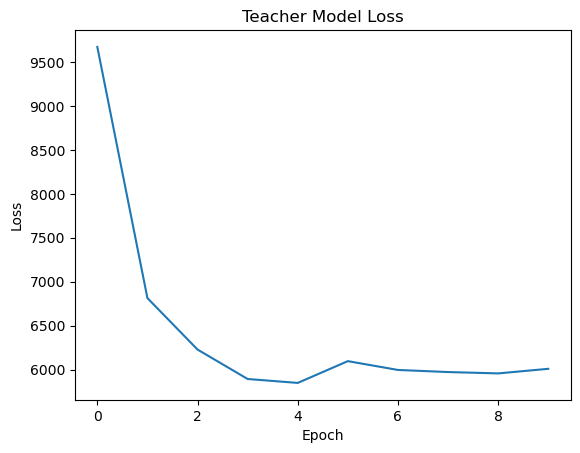

In [8]:
# plot loss curve
plt.plot(teacher_train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Teacher Model Loss")
plt.show()

# plot val curve
plt.plot(teacher_val_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Teacher Model Validation Loss")
plt.show()
            
torch.save(teacher.state_dict(), 'models/teacher_final.pth')
torch.save(decoder.state_dict(), 'models/decoder_final.pth')

In [3]:
teacher = Model(k=k).to(device)
teacher.load_state_dict(torch.load('models/teacher.pth', map_location=device))

mvtec_train_data = np.load('data/mvtec_train_point_clouds.npy')

mvtec_train_dataset = ADDataset(mvtec_train_data[:500], k=k)
mvtec_train_loader = DataLoader(mvtec_train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate_fn)

mvtec_train_tmp = DataLoader(mvtec_train_dataset, batch_size=len(mvtec_train_dataset), shuffle=True, collate_fn=custom_collate_fn)

# Initialize student model with random weights    
student = Model(k=k, is_student=True).to(device)
student_optimizer = torch.optim.Adam(student.parameters(), lr=1e-3, weight_decay=1e-5)

n_student_epochs = 5 # 100
teacher.eval()
for param in teacher.parameters():
    param.requires_grad = False

In [4]:
for i, (points, nearest_neighbors, nnbrs) in enumerate(mvtec_train_tmp):
    mean, std = get_teacher_features_distr(teacher, points.to(device), nearest_neighbors.to(device), device)

In [7]:
# criterion = nn.MSELoss()
student.train()
print("Training student model")
student_losses = []
for epoch in tqdm(range(n_student_epochs)):
    batch_loop = time.perf_counter()
    total_loss = 0.0
    for i, (points, nearest_neighbors, nnbrs) in enumerate(mvtec_train_loader):
        # f_S = torch.zeros(64000, 64) # TODO: reinit the student model?
        student_optimizer.zero_grad()
        with torch.no_grad():
            f_T = teacher(points.to(device), torch.zeros(points.shape[0], n_points, 64).to(device), nearest_neighbors.to(device))
        
        f_S = student(points.to(device), torch.zeros(points.shape[0], n_points, 64).to(device), nearest_neighbors.to(device))
        
        loss = normalized_mse_loss(f_S, f_T, mean.to(device), std.to(device))
        # loss = criterion(f_S, f_T)
        loss.backward()
        total_loss += loss.item()
        student_optimizer.step()
        
        if i % 50 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")

    print(f"Epoch {epoch} time: {time.perf_counter() - batch_loop}. Loss: {total_loss}")
    student_losses.append(loss.item())
        

Training student model


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, Iteration 0, Loss: 1.0713168382644653
Epoch 0, Iteration 50, Loss: 0.8883275389671326
Epoch 0, Iteration 100, Loss: 0.8907670974731445
Epoch 0, Iteration 150, Loss: 0.9695898294448853
Epoch 0, Iteration 200, Loss: 0.21617229282855988
Epoch 0, Iteration 250, Loss: 0.137253999710083
Epoch 0, Iteration 300, Loss: 0.025900105014443398
Epoch 0, Iteration 350, Loss: 0.014516963623464108
Epoch 0, Iteration 400, Loss: 0.01521553285419941
Epoch 0, Iteration 450, Loss: 0.016783002763986588


 20%|██        | 1/5 [02:02<08:11, 122.98s/it]

Epoch 0 time: 122.98250120971352. Loss: 194.24458860140294
Epoch 1, Iteration 0, Loss: 0.015537634491920471
Epoch 1, Iteration 50, Loss: 0.015950476750731468
Epoch 1, Iteration 100, Loss: 0.01374740432947874
Epoch 1, Iteration 150, Loss: 0.01349396351724863
Epoch 1, Iteration 200, Loss: 0.01798832044005394
Epoch 1, Iteration 250, Loss: 0.012968858703970909
Epoch 1, Iteration 300, Loss: 0.021558750420808792
Epoch 1, Iteration 350, Loss: 0.013077993877232075
Epoch 1, Iteration 400, Loss: 0.013622811064124107
Epoch 1, Iteration 450, Loss: 0.015153760090470314


 40%|████      | 2/5 [03:59<05:57, 119.17s/it]

Epoch 1 time: 116.49661542288959. Loss: 8.853723396547139
Epoch 2, Iteration 0, Loss: 0.025279466062784195
Epoch 2, Iteration 50, Loss: 0.011771528981626034
Epoch 2, Iteration 100, Loss: 0.015271623618900776
Epoch 2, Iteration 150, Loss: 0.01228354498744011
Epoch 2, Iteration 200, Loss: 0.0193722415715456
Epoch 2, Iteration 250, Loss: 0.01946205645799637
Epoch 2, Iteration 300, Loss: 0.0185317974537611
Epoch 2, Iteration 350, Loss: 0.019211996346712112
Epoch 2, Iteration 400, Loss: 0.014199523255228996
Epoch 2, Iteration 450, Loss: 0.017729368060827255


 60%|██████    | 3/5 [05:56<03:56, 118.35s/it]

Epoch 2 time: 117.37809835281223. Loss: 9.098804865032434
Epoch 3, Iteration 0, Loss: 0.016619889065623283
Epoch 3, Iteration 50, Loss: 0.021256152540445328
Epoch 3, Iteration 100, Loss: 0.013261668384075165
Epoch 3, Iteration 150, Loss: 0.01241119671612978
Epoch 3, Iteration 200, Loss: 0.013096196576952934
Epoch 3, Iteration 250, Loss: 0.02687671221792698
Epoch 3, Iteration 300, Loss: 0.01836421713232994
Epoch 3, Iteration 350, Loss: 0.018062885850667953
Epoch 3, Iteration 400, Loss: 0.02153795026242733
Epoch 3, Iteration 450, Loss: 0.027383780106902122


 80%|████████  | 4/5 [07:56<01:58, 118.74s/it]

Epoch 3 time: 119.32440627552569. Loss: 8.818964829668403
Epoch 4, Iteration 0, Loss: 0.030171288177371025
Epoch 4, Iteration 50, Loss: 0.0206740889698267
Epoch 4, Iteration 100, Loss: 0.023983409628272057
Epoch 4, Iteration 150, Loss: 0.015053866431117058
Epoch 4, Iteration 200, Loss: 0.015089497901499271
Epoch 4, Iteration 250, Loss: 0.01355070248246193
Epoch 4, Iteration 300, Loss: 0.012478817254304886
Epoch 4, Iteration 350, Loss: 0.016562506556510925
Epoch 4, Iteration 400, Loss: 0.019048186019062996
Epoch 4, Iteration 450, Loss: 0.019600508734583855


100%|██████████| 5/5 [09:52<00:00, 118.55s/it]

Epoch 4 time: 116.57468711771071. Loss: 8.782429069280624


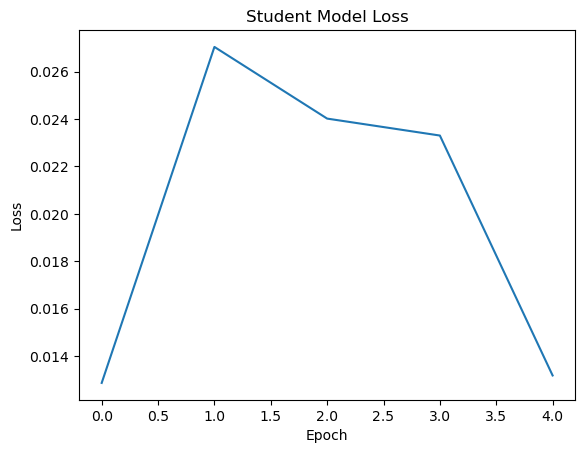

In [8]:
plt.plot(student_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Student Model Loss")
plt.show()

torch.save(student.state_dict(), 'models/student.pth')